A.S. Lundervold, v111022

# Setup

In [1]:
%matplotlib inline

import numpy as np, pandas as pd
import matplotlib.pyplot as plt 
from pathlib import Path
import seaborn as sns 
import sklearn
from sklearn import datasets

In [2]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or on Kaggle, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
try:
    import colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# Imputering

> Hvordan håndtere manglende verdier? 

1. Først må de **detekteres**. I praksis kan manglende verdier være kodet på omtrent hvilken som helst måte. Ofte bruker man blanke verdier, placeholder-verdier (f.eks. -1) eller NaNs (not-a-number).

2. Deretter kan man _imputere_. Det vil si, fylle inn manglende data

# Data

In [3]:
NB_DIR = Path.cwd()
DATA = NB_DIR/'data'
DATA.mkdir(exist_ok=True)

Vi bruker datasettet fra innlevering 1:

In [4]:
train = pd.read_csv('https://www.dropbox.com/s/zwrfpg7ww6mj5bz/housing_train_missing.csv?dl=1')
test = pd.read_csv('https://www.dropbox.com/s/03y7zsdbcb4xouw/housing_test_missing.csv?dl=1')

In [5]:
train.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.33     37.92                26.0       3887.0           779.0   
1    -122.19     37.79                45.0       2718.0           451.0   
2    -117.62     34.07                15.0       4061.0           811.0   
3    -121.92     37.68                23.0       1655.0           223.0   
4    -117.13     32.91                15.0       1450.0           266.0   

   population  households  median_income  median_house_value ocean_proximity  
0      2512.0       740.0         2.2301            122400.0        NEAR BAY  
1      1106.0       454.0         4.6563            231800.0        NEAR BAY  
2      2884.0       734.0         3.3936            127000.0          INLAND  
3       706.0       219.0         7.2211            291900.0       <1H OCEAN  
4       747.0       290.0         3.6111            196300.0       <1H OCEAN

In [6]:
test.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.23     37.81                16.0       2085.0           342.0   
1    -122.22     37.48                47.0       2570.0           783.0   
2    -122.46     37.78                52.0       2165.0           580.0   
3    -118.12     33.90                35.0       3478.0           730.0   
4    -124.03     40.45                34.0       1006.0           213.0   

   population  households  median_income ocean_proximity  
0      1236.0         NaN         5.5591          INLAND  
1      3107.0         NaN         2.8058      NEAR OCEAN  
2      1067.0       530.0            NaN        NEAR BAY  
3      1885.0       673.0         2.9375       <1H OCEAN  
4       443.0       158.0         2.6094       <1H OCEAN

Historien vi skal fortelle om dette har behov for at vi er i en maskinlærings-situasjon med X, y og trenings- og test-data:

In [7]:
X_train, y_train = train.drop(columns='median_house_value'), train.median_house_value
X_test = test

## 1. Detektere manglende verdier

Det første man typisk undersøker er hvorvidt det er NaN-verdier i datasettet. Hvis en arbeider med en Pandas dataframe er dette enkelt: 

In [8]:
X_train.head(10)

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.33     37.92                26.0       3887.0           779.0   
1    -122.19     37.79                45.0       2718.0           451.0   
2    -117.62     34.07                15.0       4061.0           811.0   
3    -121.92     37.68                23.0       1655.0           223.0   
4    -117.13     32.91                15.0       1450.0           266.0   
5    -122.49     37.78                46.0       3304.0           792.0   
6    -122.28     37.52                29.0       1526.0           355.0   
7    -119.49     34.39                17.0       4617.0           982.0   
8    -119.88     34.44                27.0       4724.0           793.0   
9    -121.28     38.66                17.0       7741.0          1401.0   

   population  households  median_income ocean_proximity  
0      2512.0       740.0         2.2301        NEAR BAY  
1      1106.0       454.0         4.6563        NEAR BAY  
2      2884.0       734.0         3.3936          INLAND  
3       706.0       219.0         7.2211       <1H OCEAN  
4       747.0       290.0         3.6111       <1H OCEAN  
5      1783.0         NaN         3.6148        NEAR BAY  
6       724.0       315.0         4.0313      NEAR OCEAN  
7      2303.0         NaN         3.9224             NaN  
8      2394.0       738.0         5.5954             NaN  
9      3153.0      1331.0         3.7869          INLAND

In [9]:
X_train.isna()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0          False     False               False        False           False   
1          False     False               False        False           False   
2          False     False               False        False           False   
3          False     False               False        False           False   
4          False     False               False        False           False   
...          ...       ...                 ...          ...             ...   
16507      False     False               False        False           False   
16508      False     False               False        False           False   
16509      False     False               False        False           False   
16510      False     False               False        False           False   
16511      False     False               False        False           False   

       population  households  median_income  ocean_proximity  
0           False       False          False            False  
1           False       False          False            False  
2           False       False          False            False  
3           False       False          False            False  
4           False       False          False            False  
...           ...         ...            ...              ...  
16507       False       False           True            False  
16508       False       False          False            False  
16509       False       False          False            False  
16510       False       False          False            False  
16511       False       False          False            False  

[16512 rows x 9 columns]

In [10]:
X_train.isna().sum()

longitude                0
latitude                 0
housing_median_age       0
total_rooms              0
total_bedrooms         165
population               0
households            2477
median_income         1486
ocean_proximity       2476
dtype: int64

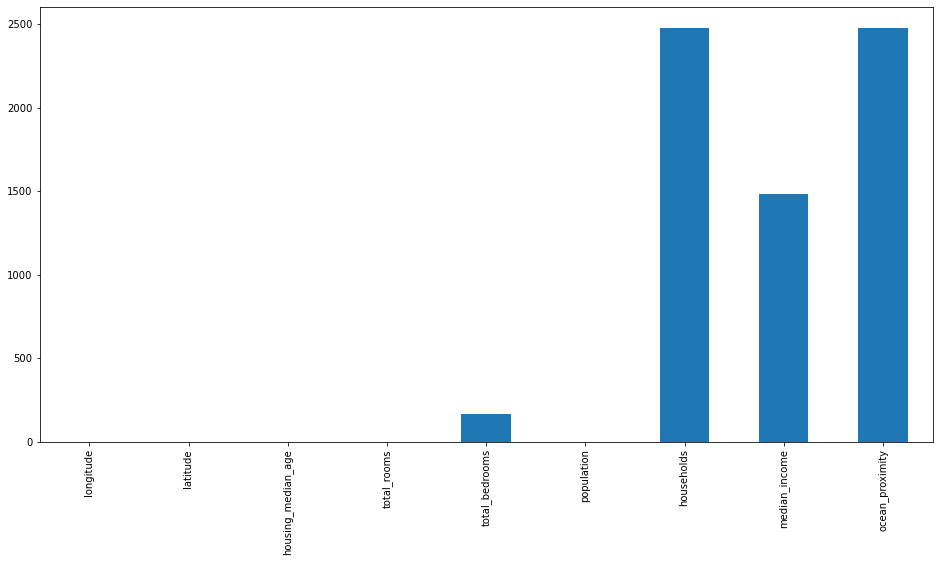

In [11]:
plt.figure(figsize=(16,8))
X_train.isna().sum().plot(kind='bar')
plt.show()

Men manglende verdier kan være kodet annerledes. En måte å finne disse er å se på hvilke verdier som finnes i datasettet. 

I vårt tilfelle er features kodet fly-tall og strenger. Manglende verdier kan f.eks. være representert som -1 eller som tomme strenger " ", men vi kan ikke se bort fra at representasjonene av manglende verdier kan være en annen.

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16347 non-null  float64
 5   population          16512 non-null  float64
 6   households          14035 non-null  float64
 7   median_income       15026 non-null  float64
 8   ocean_proximity     14036 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.1+ MB


Hvis features ikke har for mange ulike verdier er det nyttig å telle opp antall instanser som har hver verdi:

In [13]:
for feature in X_train.columns: 
    print(f"Value count for {feature}")
    with pd.option_context('display.max_rows', None): 
        print(X_train[feature].value_counts())
    print("#"*40)

Value count for longitude
-118.30    125
-118.31    123
-118.32    120
-118.27    115
-118.19    113
-118.28    111
-118.29    111
-118.35    110
-118.36    108
-118.25    104
-118.20    101
-118.37    101
-118.15     99
-118.26     98
-118.13     98
-118.12     97
-118.18     97
-118.21     96
-118.34     96
-118.14     96
-118.24     87
-118.17     85
-118.38     84
-118.43     84
-118.10     83
-118.42     83
-117.96     82
-118.09     82
-118.33     81
-117.90     81
-118.44     81
-118.41     81
-118.40     80
-118.22     80
-122.27     78
-118.16     78
-117.97     77
-117.95     77
-122.04     76
-118.23     75
-122.26     75
-118.39     75
-122.08     74
-117.92     74
-118.08     74
-122.41     74
-122.25     74
-118.11     73
-122.42     73
-122.28     72
-117.93     70
-117.25     67
-117.99     67
-122.02     67
-122.43     67
-117.09     66
-117.98     66
-118.46     65
-122.03     65
-122.07     65
-117.88     64
-118.06     64
-118.45     63
-117.08     63
-117.91     63

1227.0     22
761.0      20
850.0      20
1098.0     19
1052.0     19
1086.0     19
782.0      18
926.0      18
855.0      18
804.0      18
891.0      18
1155.0     18
1047.0     17
810.0      17
984.0      17
704.0      17
913.0      17
859.0      17
1301.0     17
928.0      16
899.0      16
848.0      16
1193.0     16
1006.0     16
970.0      16
1208.0     16
1092.0     16
999.0      16
1312.0     16
861.0      16
933.0      16
779.0      16
753.0      16
943.0      16
852.0      16
793.0      16
1158.0     16
986.0      16
1128.0     16
731.0      16
1200.0     16
705.0      16
1005.0     16
1203.0     16
781.0      16
857.0      15
862.0      15
910.0      15
788.0      15
825.0      15
679.0      15
937.0      15
872.0      15
918.0      15
735.0      15
768.0      15
837.0      15
774.0      15
939.0      15
671.0      15
823.0      15
887.0      15
1304.0     15
863.0      15
1074.0     15
973.0      15
1277.0     15
846.0      15
811.0      15
883.0      15
1257.0     15
868.0 

* Vi observerer at verdien -1 opptrer to ganger i `total_bedrooms` og verdien 99999 én gang. Disse verdiene indikerer trolig manglende verdier. 
* I `ocean_proximity` finner vi en tom streng " " én gang. Dette er også trolig en indikasjon på manglende verdi.

Vi gjør det samme med testsettet:

In [14]:
for feature in X_test.columns: 
    print(f"Value count for {feature}")
    with pd.option_context('display.max_rows', None): 
        print(X_test[feature].value_counts())
    print("#"*40)

Value count for longitude
-118.31    39
-118.29    37
-118.30    35
-118.28    30
-118.36    30
-118.35    30
-118.27    29
-118.14    29
-118.37    27
-118.11    27
-118.10    26
-122.27    25
-118.08    25
-118.20    25
-118.16    25
-117.93    24
-118.25    24
-117.87    23
-118.26    23
-118.34    23
-118.13    23
-122.01    23
-118.18    23
-118.38    23
-117.25    22
-118.43    22
-117.98    22
-118.21    22
-118.19    22
-118.32    22
-122.41    22
-122.26    21
-118.17    21
-118.39    21
-118.33    21
-122.43    21
-117.99    21
-122.42    21
-122.25    20
-118.22    20
-122.04    20
-122.17    20
-122.28    20
-122.29    19
-117.91    19
-118.07    19
-122.44    19
-117.13    19
-117.07    19
-117.90    19
-117.24    19
-121.87    18
-117.89    18
-118.02    18
-122.03    18
-118.40    18
-117.94    18
-117.27    18
-118.15    17
-117.08    17
-122.23    17
-117.97    17
-118.23    16
-122.48    16
-117.69    16
-117.95    16
-117.92    16
-118.45    16
-121.89    16
-118.41 

287.0     14
373.0     14
342.0     13
420.0     13
324.0     13
559.0     13
390.0     12
328.0     12
399.0     12
431.0     12
347.0     12
313.0     12
348.0     12
278.0     12
428.0     12
280.0     12
419.0     11
438.0     11
322.0     11
272.0     11
361.0     11
292.0     11
364.0     11
366.0     11
359.0     11
224.0     11
423.0     11
488.0     11
282.0     11
360.0     11
408.0     11
307.0     11
375.0     10
314.0     10
353.0     10
227.0     10
417.0     10
294.0     10
269.0     10
497.0     10
262.0     10
461.0     10
365.0     10
498.0     10
406.0     10
395.0     10
321.0     10
264.0     10
285.0     10
508.0     10
378.0     10
435.0     10
372.0     10
396.0     10
202.0     10
662.0     10
323.0      9
356.0      9
275.0      9
380.0      9
250.0      9
312.0      9
397.0      9
301.0      9
524.0      9
338.0      9
371.0      9
466.0      9
351.0      9
271.0      9
309.0      9
246.0      9
487.0      9
493.0      9
339.0      9
346.0      9
606.0      9

* Vi finner verdien -1 i featuren `households` én gang. Indikerer trolig manglende verdi.

### Fiks encoding av manglende verdier

Basert på disse observasjonene så skifter vi encoding av manglende verdier slik at den blir konsistent. (Siden det gjelder såpass få instanser kan vi gjøre dette manuelt)

**Train**

In [15]:
X_train.loc[X_train.total_bedrooms==-1]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
504      -122.00     37.36                17.0       2070.0            -1.0   
16272    -121.19     38.71                11.0       4415.0            -1.0   

       population  households  median_income ocean_proximity  
504         797.0       275.0         8.6155       <1H OCEAN  
16272      1520.0       627.0         3.2321          INLAND

In [16]:
X_train.loc[X_train.total_bedrooms==99999]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
88    -116.93     32.79                19.0       3354.0         99999.0   

    population  households  median_income ocean_proximity  
88      1948.0       682.0         3.0192       <1H OCEAN

In [17]:
X_train.loc[504, 'total_bedrooms'] = np.nan
X_train.loc[16272, 'total_bedrooms'] = np.nan
X_train.loc[88, 'total_bedrooms'] = np.nan

In [18]:
X_train.loc[X_train.ocean_proximity == " "]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
16489     -117.9      33.6                25.0       2465.0           585.0   

       population  households  median_income ocean_proximity  
16489       906.0       472.0         3.6538

In [19]:
X_train.loc[16489, 'ocean_proximity'] = np.nan

**Test**

In [20]:
X_test.loc[X_test.households == -1]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
26    -118.17     33.83                45.0       1808.0           315.0   

    population  households  median_income ocean_proximity  
26       800.0        -1.0         4.8693      NEAR OCEAN

In [21]:
X_test.loc[504, 'households'] = np.nan

**Sjekk**

In [22]:
X_train.isna().sum()

longitude                0
latitude                 0
housing_median_age       0
total_rooms              0
total_bedrooms         168
population               0
households            2477
median_income         1486
ocean_proximity       2477
dtype: int64

In [23]:
X_test.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms         39
population              0
households            454
median_income         334
ocean_proximity       454
dtype: int64

## 2. Imputere

Det neste blir å erstatte disse NaN-verdiene. Som dere har sett tidligere så er det mange ulike strategier. 

### Enkle strategier

Vi starter med noen enkle strategier: for de numeriske søylene kan vi erstatte verdiene ved å bruke gjennomsnitt, median eller den hyppigste verdien

In [24]:
from sklearn.impute import SimpleImputer

In [25]:
?SimpleImputer

In [26]:
imp = SimpleImputer(strategy='mean')

Merk at man kan bruke samme strategi for hver feature, eller ulike strategier for ulike features.

For de kategoriske features (`ocean_proximity` i vårt tilfelle) kan vi bruke `most_frequent` som strategi. 

Her er pipelines som behandler numeriske og kategoriske features hver for seg:

In [27]:
from sklearn.pipeline import make_pipeline

numerical_pipeline = make_pipeline(SimpleImputer(strategy="median"))

categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),)

Vi kan bruke disse på våre data via en `columns_selector` og en `column_transformer`:

In [28]:
from sklearn.compose import make_column_selector, make_column_transformer

impute = make_column_transformer(
    (numerical_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include=object)),
)

In [29]:
X_test.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -121.23     37.81                16.0       2085.0           342.0   
1    -122.22     37.48                47.0       2570.0           783.0   
2    -122.46     37.78                52.0       2165.0           580.0   
3    -118.12     33.90                35.0       3478.0           730.0   
4    -124.03     40.45                34.0       1006.0           213.0   

   population  households  median_income ocean_proximity  
0      1236.0         NaN         5.5591          INLAND  
1      3107.0         NaN         2.8058      NEAR OCEAN  
2      1067.0       530.0            NaN        NEAR BAY  
3      1885.0       673.0         2.9375       <1H OCEAN  
4       443.0       158.0         2.6094       <1H OCEAN

In [30]:
X_train_imp = impute.fit_transform(X_train)
X_test_imp = impute.transform(X_test) # NB: Note that there's no "fit" for the test data

> ***Hvorfor bruker man `.fit_transform` på treningssettet, men `.transform` på test-settet?***

In [31]:
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)
X_test_imp = pd.DataFrame(X_test_imp, columns=X_test.columns)

In [32]:
X_train_imp.head(10)

longitude latitude housing_median_age total_rooms total_bedrooms population  \
0   -122.33    37.92               26.0      3887.0          779.0     2512.0   
1   -122.19    37.79               45.0      2718.0          451.0     1106.0   
2   -117.62    34.07               15.0      4061.0          811.0     2884.0   
3   -121.92    37.68               23.0      1655.0          223.0      706.0   
4   -117.13    32.91               15.0      1450.0          266.0      747.0   
5   -122.49    37.78               46.0      3304.0          792.0     1783.0   
6   -122.28    37.52               29.0      1526.0          355.0      724.0   
7   -119.49    34.39               17.0      4617.0          982.0     2303.0   
8   -119.88    34.44               27.0      4724.0          793.0     2394.0   
9   -121.28    38.66               17.0      7741.0         1401.0     3153.0   

  households median_income ocean_proximity  
0      740.0        2.2301        NEAR BAY  
1      454.0        4.6563        NEAR BAY  
2      734.0        3.3936          INLAND  
3      219.0        7.2211       <1H OCEAN  
4      290.0        3.6111       <1H OCEAN  
5      408.0        3.6148        NEAR BAY  
6      315.0        4.0313      NEAR OCEAN  
7      408.0        3.9224       <1H OCEAN  
8      738.0        5.5954       <1H OCEAN  
9     1331.0        3.7869          INLAND

Ingen flere missing values:

In [33]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   longitude           16512 non-null  object
 1   latitude            16512 non-null  object
 2   housing_median_age  16512 non-null  object
 3   total_rooms         16512 non-null  object
 4   total_bedrooms      16512 non-null  object
 5   population          16512 non-null  object
 6   households          16512 non-null  object
 7   median_income       16512 non-null  object
 8   ocean_proximity     16512 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


In [34]:
X_test_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4128 entries, 0 to 4127
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   longitude           4128 non-null   object
 1   latitude            4128 non-null   object
 2   housing_median_age  4128 non-null   object
 3   total_rooms         4128 non-null   object
 4   total_bedrooms      4128 non-null   object
 5   population          4128 non-null   object
 6   households          4128 non-null   object
 7   median_income       4128 non-null   object
 8   ocean_proximity     4128 non-null   object
dtypes: object(9)
memory usage: 290.4+ KB


I noen situasjoner kan det være nyttig informasjon for prediktive modeller i hvorvidt features mangler eller ikke. Slik informasjon kan bevares ved å sette inn indikator-søyler:

In [35]:
numerical_pipeline = make_pipeline(SimpleImputer(strategy="median", add_indicator=True))
categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent", add_indicator=True))
impute = make_column_transformer(
    (numerical_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include=object)),
)

In [36]:
X_train_imp_ind = impute.fit_transform(X_train)

In [37]:
X_train_imp_ind = pd.DataFrame(X_train_imp_ind)

In [38]:
X_train_imp_ind.head(10)

0      1     2       3       4       5       6       7    8    9    10  \
0 -122.33  37.92  26.0  3887.0   779.0  2512.0   740.0  2.2301  0.0  0.0  0.0   
1 -122.19  37.79  45.0  2718.0   451.0  1106.0   454.0  4.6563  0.0  0.0  0.0   
2 -117.62  34.07  15.0  4061.0   811.0  2884.0   734.0  3.3936  0.0  0.0  0.0   
3 -121.92  37.68  23.0  1655.0   223.0   706.0   219.0  7.2211  0.0  0.0  0.0   
4 -117.13  32.91  15.0  1450.0   266.0   747.0   290.0  3.6111  0.0  0.0  0.0   
5 -122.49  37.78  46.0  3304.0   792.0  1783.0   408.0  3.6148  0.0  1.0  0.0   
6 -122.28  37.52  29.0  1526.0   355.0   724.0   315.0  4.0313  0.0  0.0  0.0   
7 -119.49  34.39  17.0  4617.0   982.0  2303.0   408.0  3.9224  0.0  1.0  0.0   
8 -119.88  34.44  27.0  4724.0   793.0  2394.0   738.0  5.5954  0.0  0.0  0.0   
9 -121.28  38.66  17.0  7741.0  1401.0  3153.0  1331.0  3.7869  0.0  0.0  0.0   

           11     12  
0    NEAR BAY  False  
1    NEAR BAY  False  
2      INLAND  False  
3   <1H OCEAN  False  
4   <1H OCEAN  False  
5    NEAR BAY  False  
6  NEAR OCEAN  False  
7   <1H OCEAN   True  
8   <1H OCEAN   True  
9      INLAND  False

### Mer avanserte strategier

En kan være mer spissfindig enn å imputere verdier ved å bruke verdiene til alle instanser. Man kan for eksempel finne hvilke verdier en skal erstatte med ved å bruke kun _lignende_ instanser, istedenfor alle. 

En strategi for dette er å trene en modell som kan gruppere lignende instanser. Et eksempel på dette er såkalte **K nærmeste nabo** eller KNN.  

<img width=60% src='https://upload.wikimedia.org/wikipedia/commons/thumb/e/e7/KnnClassification.svg/850px-KnnClassification.svg.png'>

In [39]:
from sklearn.impute import KNNImputer

In [40]:
?KNNImputer

In [41]:
knn_imp = KNNImputer()

In [42]:
X_train[40:50]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
40    -121.30     38.11                 5.0       5979.0          1190.0   
41    -118.06     34.08                42.0       1988.0           402.0   
42    -118.05     33.86                16.0       2851.0           626.0   
43    -115.56     32.78                34.0       2856.0           555.0   
44    -121.23     39.27                11.0       1265.0           224.0   
45    -120.62     37.35                18.0        874.0           203.0   
46    -121.96     37.54                14.0       5106.0          1207.0   
47    -121.63     39.78                28.0       1677.0           327.0   
48    -121.42     38.22                35.0       1507.0           313.0   
49    -119.04     34.22                18.0       3117.0           583.0   

    population  households  median_income ocean_proximity  
40      2679.0         NaN         4.1960          INLAND  
41      1239.0       402.0         3.2569       <1H OCEAN  
42      1985.0       603.0            NaN       <1H OCEAN  
43      1627.0       522.0            NaN          INLAND  
44       573.0       205.0         3.3603          INLAND  
45       572.0       190.0         1.6833          INLAND  
46      2738.0      1108.0         3.9909       <1H OCEAN  
47       770.0       309.0         2.6823          INLAND  
48       868.0       283.0         2.0284          INLAND  
49      2079.0       545.0         4.6458       <1H OCEAN

In [43]:
numerical_pipeline = make_pipeline(KNNImputer())
categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))
impute = make_column_transformer(
    (numerical_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include=object)),
)

In [44]:
X_train_imp = impute.fit_transform(X_train)
X_train_imp = pd.DataFrame(X_train_imp, columns=X_train.columns)

In [45]:
X_train_imp[40:50]

longitude latitude housing_median_age total_rooms total_bedrooms  \
40    -121.3    38.11                5.0      5979.0         1190.0   
41   -118.06    34.08               42.0      1988.0          402.0   
42   -118.05    33.86               16.0      2851.0          626.0   
43   -115.56    32.78               34.0      2856.0          555.0   
44   -121.23    39.27               11.0      1265.0          224.0   
45   -120.62    37.35               18.0       874.0          203.0   
46   -121.96    37.54               14.0      5106.0         1207.0   
47   -121.63    39.78               28.0      1677.0          327.0   
48   -121.42    38.22               35.0      1507.0          313.0   
49   -119.04    34.22               18.0      3117.0          583.0   

   population households median_income ocean_proximity  
40     2679.0     1118.2         4.196          INLAND  
41     1239.0      402.0        3.2569       <1H OCEAN  
42     1985.0      603.0        2.8111       <1H OCEAN  
43     1627.0      522.0       3.89862          INLAND  
44      573.0      205.0        3.3603          INLAND  
45      572.0      190.0        1.6833          INLAND  
46     2738.0     1108.0        3.9909       <1H OCEAN  
47      770.0      309.0        2.6823          INLAND  
48      868.0      283.0        2.0284          INLAND  
49     2079.0      545.0        4.6458       <1H OCEAN

### En annen strategi: tren en modell til å imputere

En annen strategi er å trene en regresjonsmodell, for eksempel en RandomForestRegressor, til å predikere manglende verdier fra verdiene som ikke mangler. 

Dette kan gjøres iterativt: i hvert steg velges en feature-søyle til å gi outputs `y`. Deretter trenes en modell på alle features uten manglende verdier til å predikere `y` ved å bruke de instansene der en kjenner verdiene av `y`. Denne modellen kan så brukes til å fylle inn. Dette kan en iterere over alle søylene til en ikke lenger har manglende verdier, og man kan gjøre det om og om igjen til en når et maksimalt antall iterasjoner. 

In [46]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [47]:
from sklearn.ensemble import RandomForestRegressor

estimator = RandomForestRegressor()

In [48]:
#?IterativeImputer

In [49]:
X_train_copy = X_train.copy()

In [50]:
X_train_copy[40:50]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
40    -121.30     38.11                 5.0       5979.0          1190.0   
41    -118.06     34.08                42.0       1988.0           402.0   
42    -118.05     33.86                16.0       2851.0           626.0   
43    -115.56     32.78                34.0       2856.0           555.0   
44    -121.23     39.27                11.0       1265.0           224.0   
45    -120.62     37.35                18.0        874.0           203.0   
46    -121.96     37.54                14.0       5106.0          1207.0   
47    -121.63     39.78                28.0       1677.0           327.0   
48    -121.42     38.22                35.0       1507.0           313.0   
49    -119.04     34.22                18.0       3117.0           583.0   

    population  households  median_income ocean_proximity  
40      2679.0         NaN         4.1960          INLAND  
41      1239.0       402.0         3.2569       <1H OCEAN  
42      1985.0       603.0            NaN       <1H OCEAN  
43      1627.0       522.0            NaN          INLAND  
44       573.0       205.0         3.3603          INLAND  
45       572.0       190.0         1.6833          INLAND  
46      2738.0      1108.0         3.9909       <1H OCEAN  
47       770.0       309.0         2.6823          INLAND  
48       868.0       283.0         2.0284          INLAND  
49      2079.0       545.0         4.6458       <1H OCEAN

In [51]:
numerical_pipeline = make_pipeline(IterativeImputer())
categorical_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent", add_indicator=True))
impute = make_column_transformer(
    (numerical_pipeline, make_column_selector(dtype_include=np.number)),
    (categorical_pipeline, make_column_selector(dtype_include=object)),
)

In [52]:
X_train_imp = impute.fit_transform(X_train)
X_train_imp = pd.DataFrame(X_train, columns=X_train.columns)

In [53]:
X_train_imp.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.33     37.92                26.0       3887.0           779.0   
1    -122.19     37.79                45.0       2718.0           451.0   
2    -117.62     34.07                15.0       4061.0           811.0   
3    -121.92     37.68                23.0       1655.0           223.0   
4    -117.13     32.91                15.0       1450.0           266.0   

   population  households  median_income ocean_proximity  
0      2512.0       740.0         2.2301        NEAR BAY  
1      1106.0       454.0         4.6563        NEAR BAY  
2      2884.0       734.0         3.3936          INLAND  
3       706.0       219.0         7.2211       <1H OCEAN  
4       747.0       290.0         3.6111       <1H OCEAN